In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from PartialIdentification import PartialIdentification
from utils import *

os.chdir(r'C:\Users\Malta\FairnessWithUnobservedProtectedClass\Warfrin')

proxy_cols = ['VKORC1..4451.', 'VKORC1.2255.', 'VKORC1.3730.', 'VKORC1.1542.', 'VKORC1.1173.', 'VKORC1.497.', 'VKORC1..1639.', 'Acetaminophen.', 'Acetaminophen.hi.dose.', 'Simvastatin.', 'Atorvastatin.', 'Fluvastatin.', 'Lovastatin.', 'Pravastatin.', 'Rosuvastatin.', 'Cerivastatin.', 'Amiodarone.', 'Carbamazepine.', 'Phenytoin.', 'Rifampin.', 'Sulfonamide.Antibiotics.', 'Macrolide.Antibiotics.', 'Anti.fungal.Azoles.', 'Herbal.Medications..Vitamins..Supplements.']
primary = pd.read_csv('primary.csv')
primary['target'] = primary['therapeut_dose'] > 35
auxiliary = pd.read_csv('auxiliary.csv')

X_cols = list(set(primary.columns).difference(('race', 'target', 'therapeut_dose')))

base_rfc = RandomForestRegressor()
base_rfc.fit(primary[X_cols], primary['therapeut_dose'])
primary['prediction'] = base_rfc.predict(primary[X_cols]) > 35


np.random.seed(42)

PI = PartialIdentification(primary,
                           auxiliary,
                           'target',
                           X_cols,
                           'race',
                           'prediction',
                           proxy_cols)

PI.generate_report()

Demographic Disparity, Asian vs all:	 (-0.4856254856254855, 0.04558860723244296)
True Positive Rate Disparity, Asian vs all:	 (-0.05412907702984049, 1.0)
True Negative Rate Disparity, Asian vs all:	 (-0.16266666666666663, 0.1649510681465568)
Demographic Disparity, Black vs all:	 (-0.3175438536537022, 0.7525416836112241)
True Positive Rate Disparity, Black vs all:	 (-0.08446298227320115, 1.0)
True Negative Rate Disparity, Black vs all:	 (-0.11050560096881634, 1.0)
Demographic Disparity, White vs all:	 (-0.27299470348180943, 0.43086567682556226)
True Positive Rate Disparity, White vs all:	 (-1.0, 0.09665427509293678)
True Negative Rate Disparity, White vs all:	 (-0.27636643571978436, 0.2048591938155715)


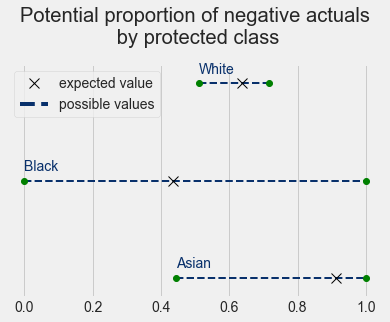

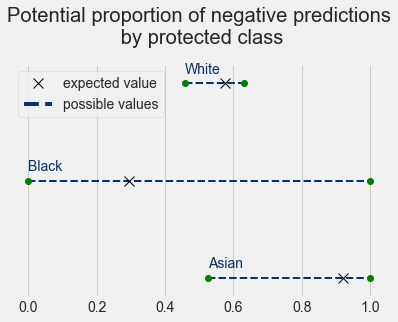

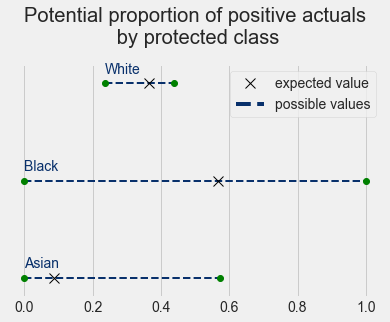

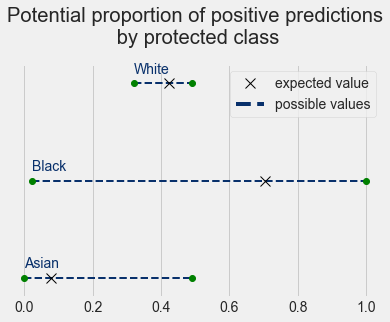

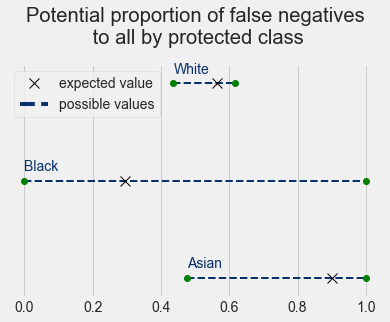

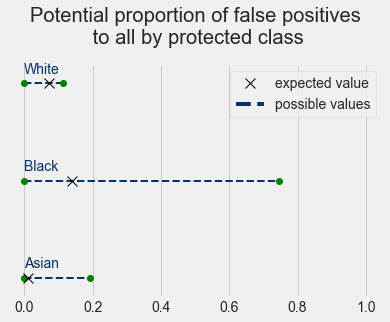

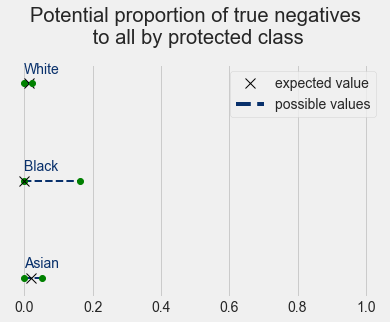

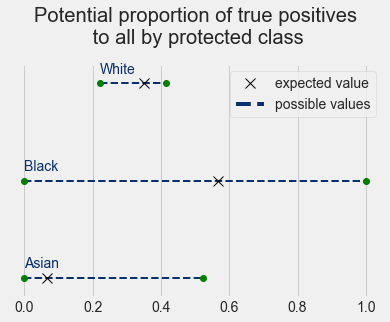

In [3]:
IN_PROTECTED_CLASS = True
NOT_IN_PROTECTED_CLASS = False

sns.set_style('dark')
plt.style.use('fivethirtyeight')

import itertools
quadrant_combos = list(
    itertools.product(
        [0, 1], [0, 1], [IN_PROTECTED_CLASS]
    )
)
hemisphere_combos = list(
    itertools.product(
        [0, 1], [True], ['truth','prediction']
    )
)

for combo in hemisphere_combos:
    intervals = []
    expected_values = []
    for protected_class in PI.protected_class_names:
        intervals.append(
            (PI.wbar_hemispheres[(*(protected_class,'lower'),*combo)],
                    PI.wbar_hemispheres[(*(protected_class,'upper'),*combo)])
        )
        expected_values.append(
            PI.wbar_hemispheres[(*(protected_class,'expectation'),*combo)]
        )
    title = 'Potential proportion of %s %s\n by protected class' % (
        {1:'positive',0:'negative'}[combo[0]],
        {'truth':'actuals','prediction':'predictions'}[combo[-1]])
    
    fig = plot_intervals_0_1(title, 
                PI.protected_class_names,
               intervals,
              expected_values)
    plt.show(fig)
    
    
for combo in quadrant_combos:
    intervals = []
    expected_values = []
    for protected_class in PI.protected_class_names:
        intervals.append(
            (PI.wbar_quadrants[(*(protected_class,'lower'),*combo)],
                    PI.wbar_quadrants[(*(protected_class,'upper'),*combo)])
        )
        expected_values.append(
            PI.wbar_quadrants[(*(protected_class,'expectation'),*combo)]
        )
    title = 'Potential proportion of %s %s\n to all by protected class' % (
        {1:'true',0:'false'}[combo[0]],
        {1:'positives',0:'negatives'}[combo[1]])
    
    fig = plot_intervals_0_1(title, 
                PI.protected_class_names,
               intervals,
              expected_values)
    plt.show(fig)
    
    
